## Import Packages

In [1]:
import numpy as np
import pandas as pd
import missingno

## Import Dataset

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()

df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['species'] = [iris.target_names[i] for i in iris.target]
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
df.species.value_counts()

,count
species,
setosa,50
versicolor,50
virginica,50


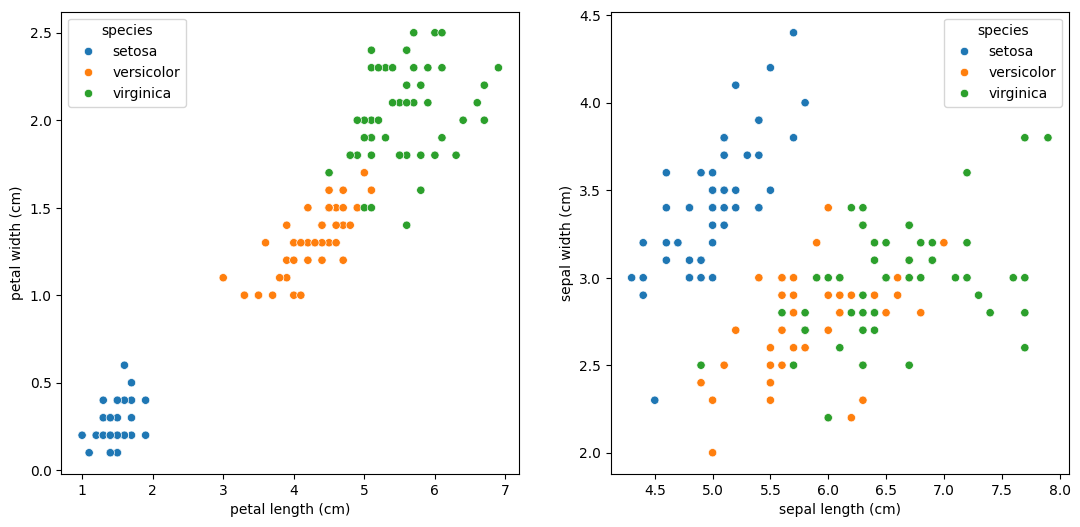

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(13, 6))
plt.subplot(121)
sns.scatterplot(data=df, x="petal length (cm)", y="petal width (cm)", hue="species")
plt.subplot(122)
sns.scatterplot(data=df, x="sepal length (cm)", y="sepal width (cm)", hue="species")
plt.show()

## Correlation Matrix

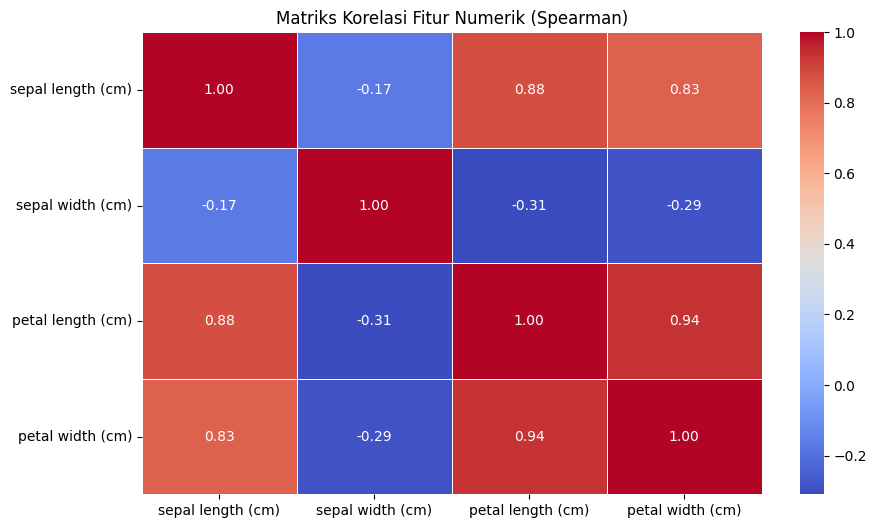

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pilih metode: "pearson", "spearman", atau "kendall"
correlation_method = "spearman"

plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include=["number"]).corr(method=correlation_method),
            annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title(f"Matriks Korelasi Fitur Numerik ({correlation_method.capitalize()})")
plt.show()

## SPLITTING

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(columns="species")
y = df["species"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120,), (30,))

## TRAINING

In [11]:
X_train.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import PowerTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('power', PowerTransformer(method='yeo-johnson')),
            ('scaler', StandardScaler())
        ]), ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']),
    ]
)

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', OneVsRestClassifier(LogisticRegression()))
])

parameter = {
    'algo__estimator__C': [0.01, 0.1, 1, 10, 100],
    'algo__estimator__max_iter': [100, 200, 500],
    'algo__estimator__fit_intercept': [True, False],
    'algo__estimator__solver': ['lbfgs', 'saga']
}

In [13]:
from sklearn.model_selection import GridSearchCV

model = GridSearchCV(pipeline, param_grid=parameter, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('power',
                                                                                          PowerTransformer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['sepal '
                                                                          'length '
                                                                          '(cm)',
                                                                          'sepal '
                                                                          'width '
                                                                          '(cm)',
                                                                          'petal '
                                                                          'length '
                                                                          '(cm)',
                                                                          'petal '
                                                                          'width '
                                                                          '(cm)'])])),
                                       ('algo',
                                        OneVsRestClassifier(estimator=LogisticRegression()))]),
             n_jobs=-1,
             param_grid={'algo__estimator__C': [0.01, 0.1, 1, 10, 100],
                         'algo__estimator__fit_intercept': [True, False],
                         'algo__estimator__max_iter': [100, 200, 500],
                         'algo__estimator__solver': ['lbfgs', 'saga']},
             verbose=1)

In [14]:
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

{'algo__estimator__C': 10, 'algo__estimator__fit_intercept': True, 'algo__estimator__max_iter': 100, 'algo__estimator__solver': 'lbfgs'}
0.9666666666666667 0.9333333333333332 0.9333333333333333


## Evaluasi Model

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average='weighted')
recall_train = recall_score(y_train, y_pred_train, average='weighted')
f1_train = f1_score(y_train, y_pred_train, average='weighted')

print(f"Jumlah data train: {X_train.shape[0]}")
print(f"Jumlah data test: {X_test.shape[0]}\n")

print("**Evaluasi pada Data Train**")
print(f"Akurasi: {accuracy_train:.4f}")
print(f"Precision: {precision_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"F1-Score: {f1_train:.4f}\n")

print("**Evaluasi pada Data Test**")
print(f"Akurasi: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")

Jumlah data train: 120
Jumlah data test: 30

**Evaluasi pada Data Train**
Akurasi: 0.9667
Precision: 0.9667
Recall: 0.9667
F1-Score: 0.9667

**Evaluasi pada Data Test**
Akurasi: 0.9333
Precision: 0.9333
Recall: 0.9333
F1-Score: 0.9333


In [17]:
from sklearn.metrics import classification_report

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Classification Report untuk Training Data
print("Classification Report - Train Data:")
print(classification_report(y_train, y_train_pred))

# Classification Report untuk Testing Data
print("\nClassification Report - Test Data:")
print(classification_report(y_test, y_test_pred))

Classification Report - Train Data:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        40
  versicolor       0.95      0.95      0.95        40
   virginica       0.95      0.95      0.95        40

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120


Classification Report - Test Data:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



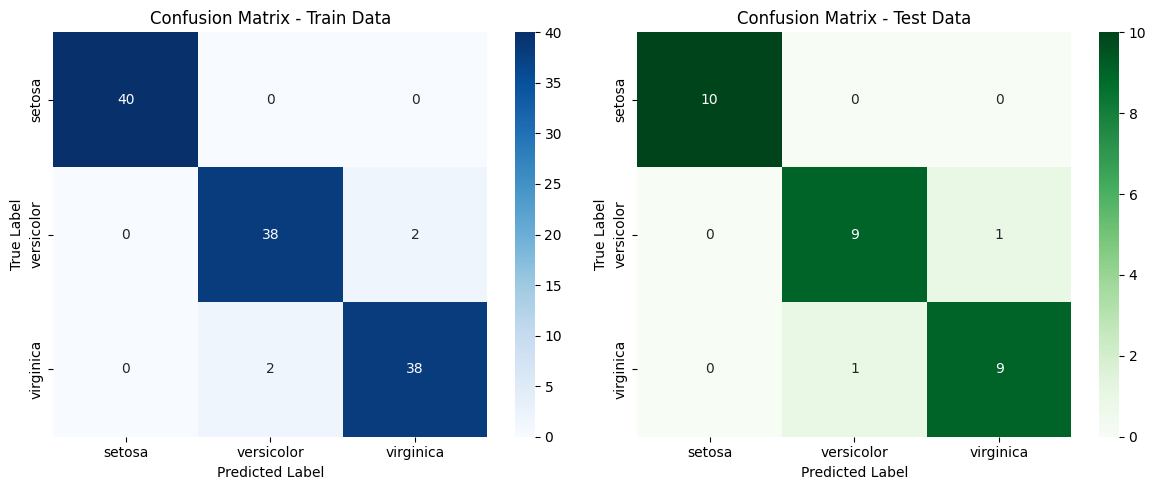

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_, ax=axes[0])
axes[0].set_title("Confusion Matrix - Train Data")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_, ax=axes[1])
axes[1].set_title("Confusion Matrix - Test Data")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()

<ipython-input-27-52ec6d8ba927>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


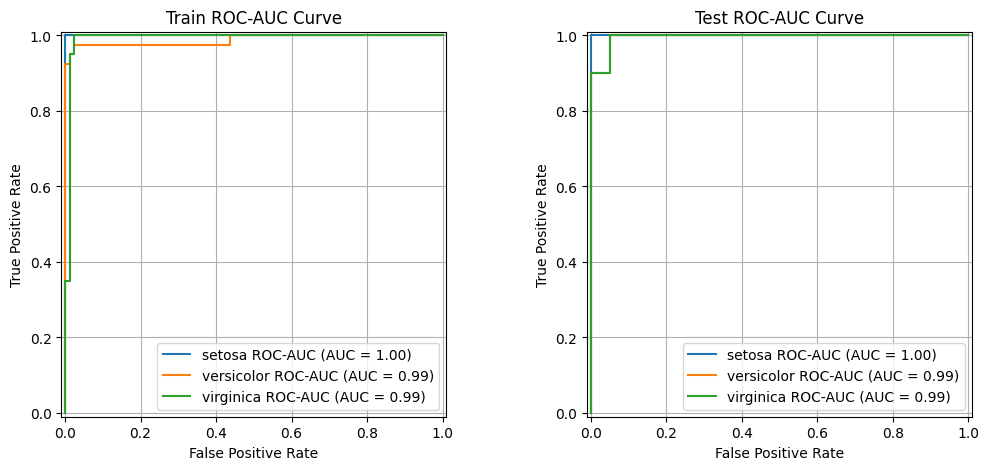

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train)
y_test_binarized = lb.transform(y_test)

class_names = lb.classes_

fig, ax = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'wspace': 0.3})

for i in range(y_train_binarized.shape[1]):
    y_train_score = model.predict_proba(X_train)[:, i]
    fpr_train, tpr_train, _ = roc_curve(y_train_binarized[:, i], y_train_score)
    roc_auc_train = auc(fpr_train, tpr_train)
    RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, roc_auc=roc_auc_train).plot(
        ax=ax[0], name=f"{class_names[i]} ROC-AUC"
    )

ax[0].set_title("Train ROC-AUC Curve")
ax[0].grid(True)

for i in range(y_test_binarized.shape[1]):
    y_test_score = model.predict_proba(X_test)[:, i]
    fpr_test, tpr_test, _ = roc_curve(y_test_binarized[:, i], y_test_score)
    roc_auc_test = auc(fpr_test, tpr_test)
    RocCurveDisplay(fpr=fpr_test, tpr=tpr_test, roc_auc=roc_auc_test).plot(
        ax=ax[1], name=f"{class_names[i]} ROC-AUC"
    )

ax[1].set_title("Test ROC-AUC Curve")
ax[1].grid(True)

plt.tight_layout()
plt.show()

<ipython-input-28-3999eb7bbdb0>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


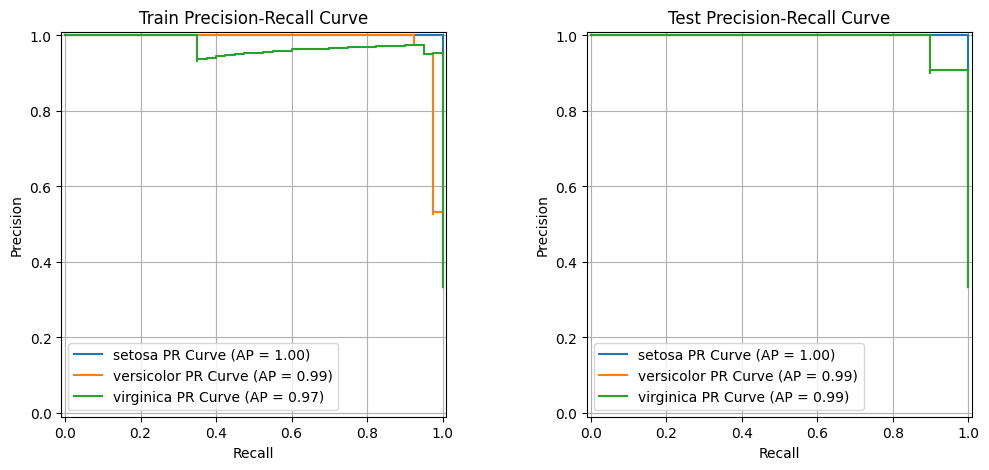

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train)
y_test_binarized = lb.transform(y_test)

class_names = lb.classes_

fig, ax = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'wspace': 0.3})

for i in range(y_train_binarized.shape[1]):
    y_train_score = model.predict_proba(X_train)[:, i]
    precision_train, recall_train, _ = precision_recall_curve(y_train_binarized[:, i], y_train_score)
    avg_precision_train = average_precision_score(y_train_binarized[:, i], y_train_score)
    PrecisionRecallDisplay(precision=precision_train, recall=recall_train, average_precision=avg_precision_train).plot(
        ax=ax[0], name=f"{class_names[i]} PR Curve"
    )

ax[0].set_title("Train Precision-Recall Curve")
ax[0].grid(True)

for i in range(y_test_binarized.shape[1]):
    y_test_score = model.predict_proba(X_test)[:, i]
    precision_test, recall_test, _ = precision_recall_curve(y_test_binarized[:, i], y_test_score)
    avg_precision_test = average_precision_score(y_test_binarized[:, i], y_test_score)
    PrecisionRecallDisplay(precision=precision_test, recall=recall_test, average_precision=avg_precision_test).plot(
        ax=ax[1], name=f"{class_names[i]} PR Curve"
    )

ax[1].set_title("Test Precision-Recall Curve")
ax[1].grid(True)

plt.tight_layout()
plt.show()

## Feature Importance

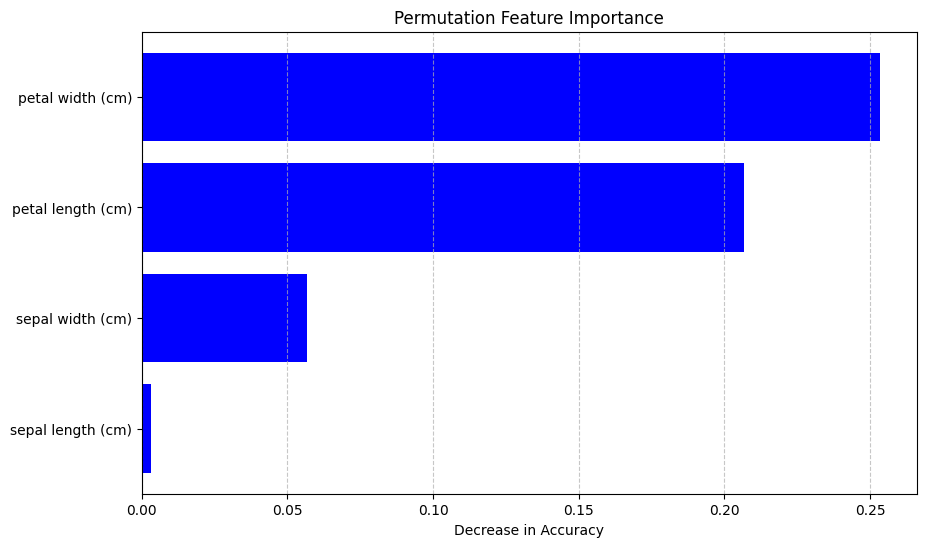

In [33]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx], color='blue')
plt.title('Permutation Feature Importance')
plt.xlabel('Decrease in Accuracy')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Prediksi

In [34]:
X_train.iloc[0]

,8
sepal length (cm),4.4
sepal width (cm),2.9
petal length (cm),1.4
petal width (cm),0.2


In [36]:
import pandas as pd

new_data = pd.DataFrame({
    'sepal length (cm)': [5.1, 6.2, 4.7, 7.3, 5.8],
    'sepal width (cm)': [3.5, 2.9, 3.2, 3.0, 3.8],
    'petal length (cm)': [1.4, 4.5, 1.6, 6.3, 5.1],
    'petal width (cm)': [0.2, 1.5, 0.4, 2.4, 1.9]
})

new_data['Predict'] = model.predict(new_data)
new_data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Predict
0,5.1,3.5,1.4,0.2,setosa
1,6.2,2.9,4.5,1.5,versicolor
2,4.7,3.2,1.6,0.4,setosa
3,7.3,3.0,6.3,2.4,virginica
4,5.8,3.8,5.1,1.9,virginica


## Save Model

In [37]:
import pickle

with open('iris.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model berhasil disimpan")

Model berhasil disimpan
